In [2]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
model_data = pd.read_csv('model_data.csv')
vali_data = pd.read_csv('vali_data.csv')

In [4]:
model_data

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0,0.015404,53,0,0.121802,4728.000000,5,0,0,0,0.000000
1,1,0,0.168311,63,0,0.141964,1119.000000,5,0,0,0,0.000000
2,2,1,1.063570,39,1,0.417663,3500.000000,5,1,0,2,3.716057
3,3,0,0.088684,73,0,0.522822,5301.000000,11,0,2,0,0.000000
4,4,1,0.622999,53,0,0.423650,13000.000000,9,0,2,0,0.181999
...,...,...,...,...,...,...,...,...,...,...,...,...
195003,195003,1,0.916269,32,2,0.548132,6000.000000,10,0,1,0,3.966830
195004,195004,1,0.484728,50,1,0.370603,5258.000000,12,0,1,0,2.000000
195005,195005,1,0.850447,46,0,0.562610,8000.000000,9,0,1,0,2.768793
195006,195006,0,1.000000,64,0,0.364694,10309.000000,7,0,3,0,0.000000


In [5]:
def graphforbestbin(DF,X,Y,n=2,q=20,graph=True):
    """
   自动最优分箱函数，基于卡方检验的分箱
   参数：
   DF: 需要输入的数据
   X: 需要分箱的列名
   Y: 分箱数据对应的标签 Y 列名
   n: 保留分箱个数
   q: 初始分箱的个数
   graph: 是否要画出IV图像
   区间为前开后闭 (]
   """
    DF = DF[[X,Y]].copy()

    DF['qcut'],bins = pd.qcut(DF[X],retbins=True,q=q,duplicates='drop')
    coount_y0 = DF.loc[DF[Y]==0].groupby(by='qcut').count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2]=[(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue
        for i in range((len(num_bins))):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1]=[(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
            else:
                break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV=[]
    axisx=[]
    while len(num_bins)>n:
        pvs=[]
        for i in range(len(num_bins)-1):
            x1=num_bins[i][2:]
            x2=num_bins[i+1][2:]
            pv=scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[1][3]+num_bins[i+1][3])]
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))

    if graph:
        plt.figure()
        plt.plot(axisx,IV) 
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df



In [6]:
model_data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

RevolvingUtilizationOfUnsecuredLines


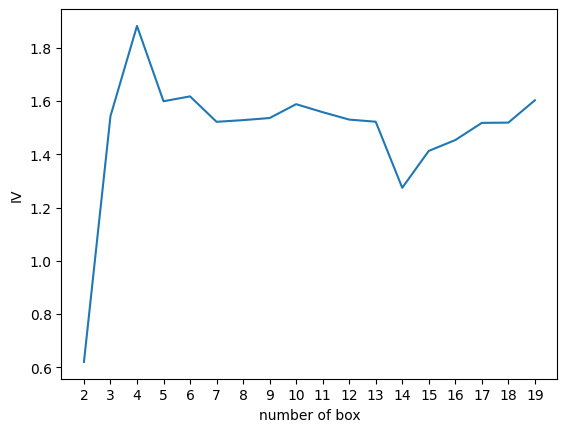

age


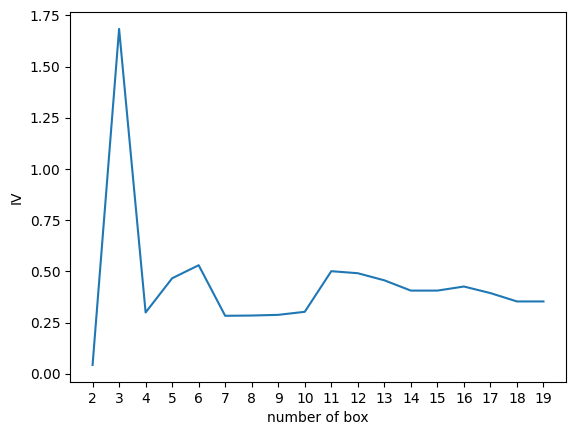

NumberOfTime30-59DaysPastDueNotWorse


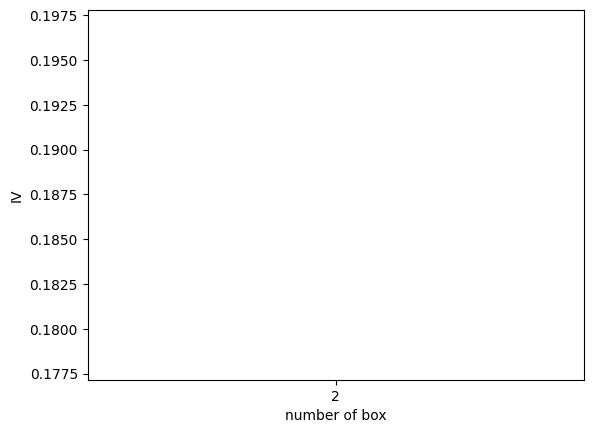

DebtRatio


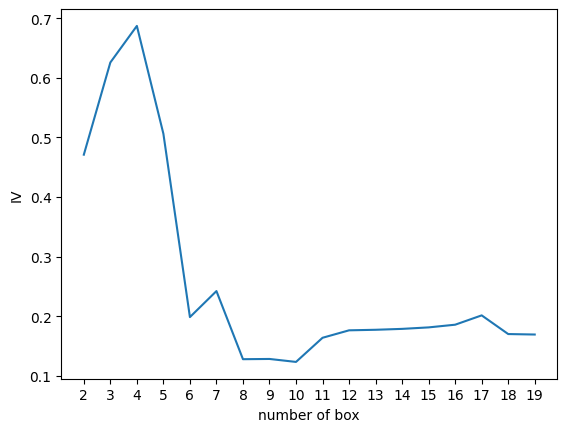

MonthlyIncome


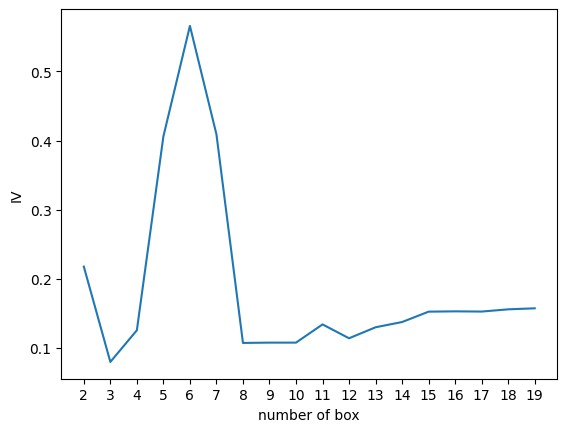

NumberOfOpenCreditLinesAndLoans


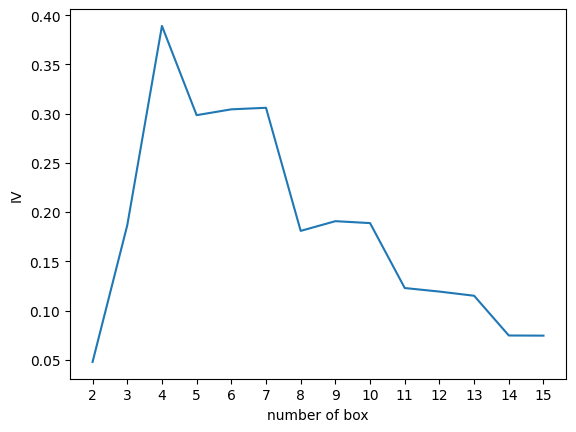

NumberOfTimes90DaysLate


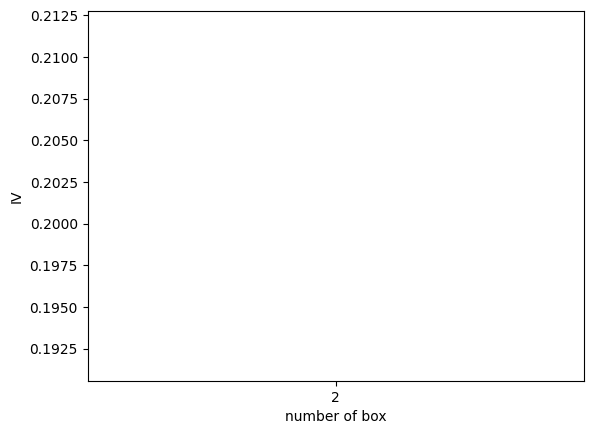

NumberRealEstateLoansOrLines


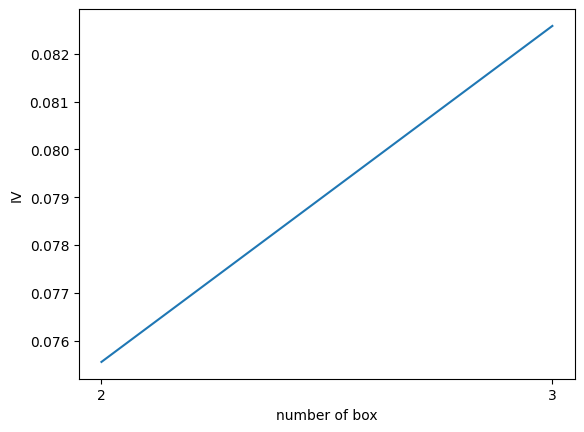

NumberOfTime60-89DaysPastDueNotWorse


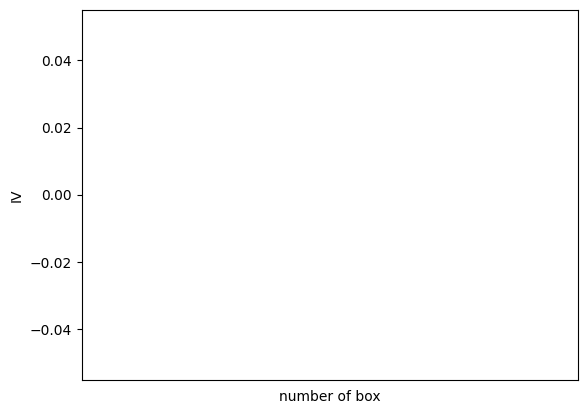

UnboundLocalError: local variable 'bins_df' referenced before assignment

In [7]:
for i in model_data.columns[2:-1]:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)
    

有些画不出图像，是因为本身就是离散变量，分不出20个箱

因此这些需要手动分箱

In [8]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
"age":5,
"DebtRatio":4,
 "MonthlyIncome":3,
 "NumberOfOpenCreditLinesAndLoans":5} #自动分箱的值
 
 #不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
 ,"NumberOfTimes90DaysLate":[0,1,2,17]
 ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
 ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
 ,"NumberOfDependents":[0,1,2,3]}
#保证区间覆盖使用 np.inf替换最大值，用-np.inf替换最小值
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [9]:
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [10]:
#*的作用
A=[1,2,3,5]
[1,A,2]

[1, [1, 2, 3, 5], 2]

In [11]:
[1,*A,2]

[1, 1, 2, 3, 5, 2]

In [12]:
bins_of_col = {}

for col in auto_col_bins:
    bins_df=graphforbestbin(model_data,col,'SeriousDlqin2yrs',n=auto_col_bins[col],q=20,graph=False)
    bins_list=sorted(set(bins_df['min']).union(bins_df['max'])) # .union 求set集合的并集
    bins_list[0],bins_list[-1]=-np.inf,np.inf
    bins_of_col[col]=bins_list

In [13]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.06049460055099112,
  0.15362815795161777,
  0.9345924369772338,
  0.9826804434059668,
  0.9999999,
  inf],
 'age': [-inf, 54.0, 61.0, 64.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01746292555,
  0.16916180913256193,
  136.7653566416627,
  inf],
 'MonthlyIncome': [-inf, 5597.6786135183065, 10244.04450711361, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 11.0, inf]}

In [14]:
#合并手动分箱数据    
bins_of_col.update(hand_bins) #.update 字典合并
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.06049460055099112,
  0.15362815795161777,
  0.9345924369772338,
  0.9826804434059668,
  0.9999999,
  inf],
 'age': [-inf, 54.0, 61.0, 64.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01746292555,
  0.16916180913256193,
  136.7653566416627,
  inf],
 'MonthlyIncome': [-inf, 5597.6786135183065, 10244.04450711361, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 11.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

计算各个箱的WOE并映射到数据中

先举个例子算age这个特征的woe

In [15]:
#其中手动的箱子中还没有woe，因此我需要重新算一遍woe
data=model_data.copy()
data

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0,0.015404,53,0,0.121802,4728.000000,5,0,0,0,0.000000
1,1,0,0.168311,63,0,0.141964,1119.000000,5,0,0,0,0.000000
2,2,1,1.063570,39,1,0.417663,3500.000000,5,1,0,2,3.716057
3,3,0,0.088684,73,0,0.522822,5301.000000,11,0,2,0,0.000000
4,4,1,0.622999,53,0,0.423650,13000.000000,9,0,2,0,0.181999
...,...,...,...,...,...,...,...,...,...,...,...,...
195003,195003,1,0.916269,32,2,0.548132,6000.000000,10,0,1,0,3.966830
195004,195004,1,0.484728,50,1,0.370603,5258.000000,12,0,1,0,2.000000
195005,195005,1,0.850447,46,0,0.562610,8000.000000,9,0,1,0,2.768793
195006,195006,0,1.000000,64,0,0.364694,10309.000000,7,0,3,0,0.000000


In [16]:
data = data[['age','SeriousDlqin2yrs']].copy()
data

,age,SeriousDlqin2yrs
0,53,0
1,63,0
2,39,1
3,73,0
4,53,1
...,...,...
195003,32,1
195004,50,1
195005,46,1
195006,64,0


In [17]:
data['cut']=pd.cut(data['age'],[-np.inf, 54.0, 61.0, 64.0, 74.0, np.inf])
data

,age,SeriousDlqin2yrs,cut
0,53,0,"(-inf, 54.0]"
1,63,0,"(61.0, 64.0]"
2,39,1,"(-inf, 54.0]"
3,73,0,"(64.0, 74.0]"
4,53,1,"(-inf, 54.0]"
...,...,...,...
195003,32,1,"(-inf, 54.0]"
195004,50,1,"(-inf, 54.0]"
195005,46,1,"(-inf, 54.0]"
195006,64,0,"(61.0, 64.0]"


In [18]:
data.groupby("cut")["SeriousDlqin2yrs"].value_counts()

cut           SeriousDlqin2yrs
(-inf, 54.0]  1                   76237
              0                   53867
(54.0, 61.0]  0                   15743
              1                   12271
(61.0, 64.0]  0                    6968
              1                    3200
(64.0, 74.0]  0                   13376
              1                    4225
(74.0, inf]   0                    7737
              1                    1384
Name: SeriousDlqin2yrs, dtype: int64

In [19]:
bins_df = data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()
bins_df

SeriousDlqin2yrs,0,1
cut,,
"(-inf, 54.0]",53867,76237
"(54.0, 61.0]",15743,12271
"(61.0, 64.0]",6968,3200
"(64.0, 74.0]",13376,4225
"(74.0, inf]",7737,1384


In [20]:
bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))

上面过程包装成函数

In [21]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df['cut']=pd.cut(df[col],bins)
    bins_df=df.groupby('cut')[y].value_counts().unstack()
    woe =bins_df['woe']=np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe

In [22]:
woeall={}
for col in bins_of_col:
    woeall[col]=get_woe(model_data,col,'SeriousDlqin2yrs',bins_of_col[col])
woeall
    

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0605]     2.426436
 (0.0605, 0.154]    1.303318
 (0.154, 0.935]    -0.499969
 (0.935, 0.983]    -1.506347
 (0.983, 1.0]      -0.470685
 (1.0, inf]        -2.042961
 dtype: float64,
 'age': cut
 (-inf, 54.0]   -0.351165
 (54.0, 61.0]    0.245321
 (61.0, 64.0]    0.774342
 (64.0, 74.0]    1.148607
 (74.0, inf]     1.717200
 dtype: float64,
 'DebtRatio': cut
 (-inf, 0.0175]      1.515419
 (0.0175, 0.169]     0.111639
 (0.169, 136.765]   -0.158426
 (136.765, inf]      0.147966
 dtype: float64,
 'MonthlyIncome': cut
 (-inf, 5597.679]        -0.124640
 (5597.679, 10244.045]    0.154023
 (10244.045, inf]         0.431720
 dtype: float64,
 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.845306
 (1.0, 3.0]    -0.332632
 (3.0, 5.0]    -0.052372
 (5.0, 11.0]    0.120028
 (11.0, inf]    0.203698
 dtype: float64,
 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.351916
 (0.0, 1.0]    -0.873126
 (1.0, 2.0]    -1.375144
 (2.

In [23]:
#接下来，把所有的woe数据映射到原始数据中

model_woe = pd.DataFrame(index=model_data.index)
model_woe

""
0
1
2
3
4
...
195003
195004
195005
195006


In [24]:
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"])
model_woe['age']

0         (-inf, 54.0]
1         (61.0, 64.0]
2         (-inf, 54.0]
3         (64.0, 74.0]
4         (-inf, 54.0]
              ...     
195003    (-inf, 54.0]
195004    (-inf, 54.0]
195005    (-inf, 54.0]
195006    (61.0, 64.0]
195007    (-inf, 54.0]
Name: age, Length: 195008, dtype: category
Categories (5, interval[float64, right]): [(-inf, 54.0] < (54.0, 61.0] < (61.0, 64.0] < (64.0, 74.0] < (74.0, inf]]

In [25]:
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])
model_woe['age']


/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0        -0.351165
1         0.774342
2        -0.351165
3         1.148607
4        -0.351165
            ...   
195003   -0.351165
195004   -0.351165
195005   -0.351165
195006    0.774342
195007   -0.351165
Name: age, Length: 195008, dtype: category
Categories (5, float64): [-0.351165 < 0.245321 < 0.774342 < 1.148607 < 1.717200]

In [26]:
for col in bins_of_col:
    model_woe[col]=pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])


model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]


In [27]:
model_woe

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.351165,2.426436,0.111639,-0.124640,-0.052372,0.351916,0.234959,-0.393044,0.124499,0.656054,0
1,0.774342,-0.499969,0.111639,-0.124640,-0.052372,0.351916,0.234959,-0.393044,0.124499,0.656054,0
2,-0.351165,-2.042961,-0.158426,-0.124640,-0.052372,-0.873126,-1.751961,-0.393044,-1.771193,-0.478533,1
3,1.148607,1.303318,-0.158426,-0.124640,0.120028,0.351916,0.234959,0.617146,0.124499,0.656054,0
4,-0.351165,-0.499969,-0.158426,0.431720,0.120028,0.351916,0.234959,0.617146,0.124499,-0.510269,1
...,...,...,...,...,...,...,...,...,...,...,...
195003,-0.351165,-0.499969,-0.158426,0.154023,0.120028,-1.375144,0.234959,0.194335,0.124499,-0.478533,1
195004,-0.351165,-0.499969,-0.158426,-0.124640,0.203698,-0.873126,0.234959,0.194335,0.124499,-0.531783,1
195005,-0.351165,-0.499969,-0.158426,0.154023,0.120028,0.351916,0.234959,0.194335,0.124499,-0.478533,1
195006,0.774342,-0.470685,-0.158426,0.431720,0.120028,0.351916,0.234959,0.384213,0.124499,0.656054,0


最终可用来建模的数据得到了

In [28]:
model_woe.to_csv('./model_woe.csv')

建模与模型验证

In [29]:
#处理测试集
vali_woe = pd.DataFrame(index=vali_data.index)
for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [31]:
#开始建模
X = model_woe.iloc[:,:-1] 
y = model_woe.iloc[:,-1]
from sklearn.linear_model import LogisticRegression as LR
lr = LR().fit(X,y)
lr.score(vali_X,vali_y)

/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.7690724609935867

In [32]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.

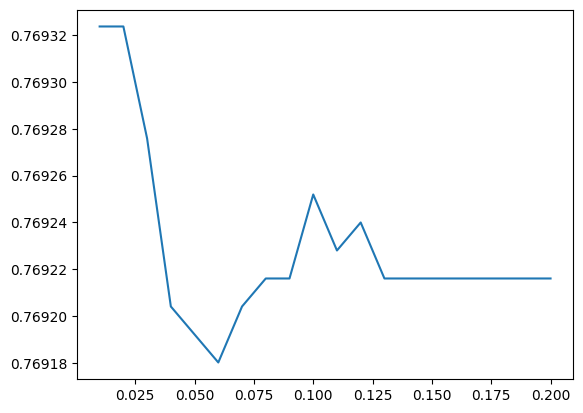

In [33]:
score = []
for i in c_2: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_2,score)
plt.show()


In [34]:
lr.n_iter_

array([5], dtype=int32)

/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(

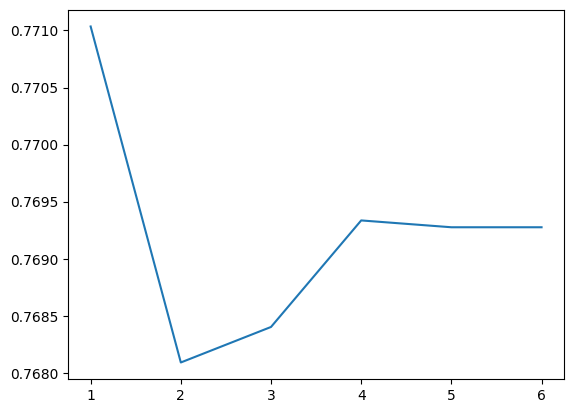

In [35]:
score = []
for i in [1,2,3,4,5,6]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6],score)
plt.show()

/Users/sampson/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

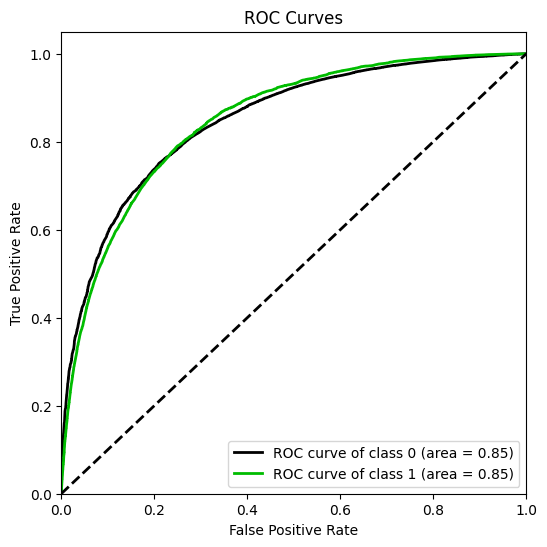

In [40]:
import scikitplot as skplt
#%%cmd
#pip install scikit-plot
vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df,
plot_micro=False,figsize=(6,6),
plot_macro=False)

制作评分卡

In [41]:
B = 20/np.log(2) 
A = 600 + B*np.log(1/60) 
B,A

(28.85390081777927, 481.8621880878296)

In [42]:
base_score = A - B*lr.intercept_
base_score
score_age = woeall["age"] * (-B*lr.coef_[0][0])
score_age

cut
(-inf, 54.0]    -3.278072
(54.0, 61.0]     2.290040
(61.0, 64.0]     7.228370
(64.0, 74.0]    10.722084
(74.0, inf]     16.029822
dtype: float64

In [44]:
file = "./ScoreData.csv"

with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")

In [46]:
final_score = pd.read_csv('ScoreData.csv')
final_score

,base_score,[481.90508501]
0,age,Score
1,"(-inf, 54.0]",-3.2780717806579127
2,"(54.0, 61.0]",2.290039726256963
3,"(61.0, 64.0]",7.228369731253498
4,"(64.0, 74.0]",10.722083803524276
5,"(74.0, inf]",16.02982214838272
6,RevolvingUtilizationOfUnsecuredLines,Score
7,"(-inf, 0.0605]",53.498614305331266
8,"(0.0605, 0.154]",28.735866962831683
9,"(0.154, 0.935]",-11.023423139727347
